# MobileNet CNN Feature Extractor and RNN Classifier

In [ ]:
# Packages
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import MobileNet

## Data Preprocessing

In this cell we convert the .wav files into spectrograms. encode the labels, and split the data into training and testing sets (80% and 20% respectively).

In [1]:
# Preprocess audio file into Mel Spectrogram
def preprocess_audio_file(file_path, target_shape=(224, 224)):
    """
    Converts a .wav file into a Mel Spectrogram, resizes it for InceptionV3, 
    and normalizes pixel values.
    """
    try:
        y, sr = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        resized_spec = resize(mel_spec_db, target_shape, mode='constant')
        rgb_spec = np.stack([resized_spec] * 3, axis=-1) / 255.0  # Normalize to [0, 1]
        return rgb_spec
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Process directory of sounds into spectrograms and labels
def process_directory_to_dataframe(parent_directory, target_shape=(224, 224)):
    """
    Processes all .wav files in a directory and its subdirectories,
    computes their Mel Spectrograms, and stores them in a DataFrame.
    """
    data, labels = [], []
    for root, _, files in os.walk(parent_directory):
        label = os.path.basename(root)  # Subdirectory name is the label
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                spectrogram = preprocess_audio_file(file_path, target_shape)
                if spectrogram is not None:
                    data.append(spectrogram)
                    labels.append(label)
    return np.array(data), np.array(labels)

# Path to the parent directory containing labeled subdirectories of .wav files
parent_directory = "Animal_Sounds"  # Replace with your dataset directory

# Process audio files and labels
print("Processing audio files...")
X, y = process_directory_to_dataframe(parent_directory)

# Encode labels
print("Encoding labels...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

Processing audio files...


Note: Illegal Audio-MPEG-Header 0x66616374 at offset 9082.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Encoding labels...
Splitting data into train and test sets...


## Feature Extraction

Loading pretrained MobileNet CNN and adding in feature extraction layers.

In [2]:
# Load pre-trained MobileNet model
print("Loading pre-trained MobileNet model...")
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a feature extractor from the pre-trained model
feature_extractor_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu')  # Feature embedding layer
])


Loading pre-trained MobileNet model...


Augmenting the data due to small data size to reduce overfitting of model and increase generalization. Then extarcting the features using the CNN we created in the pervious cell

In [3]:
# Data augmentation and training
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Extract features for training and testing data
print("Extracting features using the pre-trained MobileNet model...")
X_train_features = feature_extractor_model.predict(X_train)
X_test_features = feature_extractor_model.predict(X_test)

Extracting features using the pre-trained MobileNet model...
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


In this next cell, we prepare the data for the RNN, build the Long Short-Term Momory based RNN as follows and compile the model. 

In [4]:
# Reshape features for RNN input
timesteps = 1  # One timestep per spectrogram
X_train_rnn = X_train_features.reshape(X_train_features.shape[0], timesteps, -1)
X_test_rnn = X_test_features.reshape(X_test_features.shape[0], timesteps, -1)

# Build the RNN model
print("Building the CNN + RNN hybrid model...")

rnn_model = Sequential([
    TimeDistributed(Dense(128, activation='relu'), input_shape=(timesteps, X_train_rnn.shape[2])),
    LSTM(128, return_sequences=False),  # LSTM for temporal modeling
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # Classification layer
])

# Compile the model

optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)

rnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()

Building the CNN + RNN hybrid model...


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 1, 128)         │        32,896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,028 (648.55 KB)

 Trainable params: 166,028 (648.55 KB)

 Non-trainable params: 0 (0.00 B)

Here we are training the model and evaluating it, calculating the accuracy on the test set.  

In [5]:
# Train the model
print("Training the CNN + RNN hybrid model...")

# Early Stopping to reduce overfitting by stopping training when validation loss does not change for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning Rate Scheduler to reduce LR when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce LR by a factor of 0.5
    patience=3,          # Wait 3 epochs before reducing LR
    verbose=1,
    min_lr=1e-6          # Minimum learning rate
)

history = rnn_model.fit(
    X_train_rnn, y_train,
    validation_data=(X_test_rnn, y_test),
    epochs=50,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = rnn_model.evaluate(X_test_rnn, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Save the hybrid model
rnn_model.save("mobilenet_rnn_hybrid_model.h5")
print("Model saved as 'mobilenet_rnn_hybrid_model.h5'")

Training the CNN + RNN hybrid model...
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1642 - loss: 2.3965 - val_accuracy: 0.3543 - val_loss: 2.0539 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4434 - loss: 1.9488 - val_accuracy: 0.5486 - val_loss: 1.5407 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5750 - loss: 1.4442 - val_accuracy: 0.6514 - val_loss: 1.2445 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6459 - loss: 1.1678 - val_accuracy: 0.6571 - val_loss: 1.1422 - learning_rate: 0.0010
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6989 - loss: 1.0223 - val_accuracy: 0.6857 - val_loss: 0.9915 - learning_rate: 0.0010
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7303 - loss: 0.8664 - val_accuracy: 0.6914 - val_loss: 0.9296 - learning_rate: 0.0010
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

Test Accuracy: 0.78
Model saved as 'mobilenet_rnn_hybrid_model.h5'


We plot a report and a confusion matrix. 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Classification Report:
              precision    recall  f1-score   support

        Bear       0.44      0.50      0.47        16
        Bird       0.86      1.00      0.93        19
         Cat       0.84      0.78      0.81        27
     Chicken       0.62      0.71      0.67         7
         Cow       0.90      0.96      0.93        28
         Dog       1.00      0.83      0.91        18
     Dolphin       0.83      0.71      0.77        14
      Donkey       0.90      1.00      0.95         9
        Frog       0.87      0.87      0.87        15
        Lion       0.12      0.11      0.12         9
      Monkey       0.50      0.33      0.40         3
       Sheep       0.70      0.70      0.70        10

    accuracy                           0.78       175
   macro avg       0.72      0.71      0.71       175
weighted avg       0.78      0.78      0.77       175



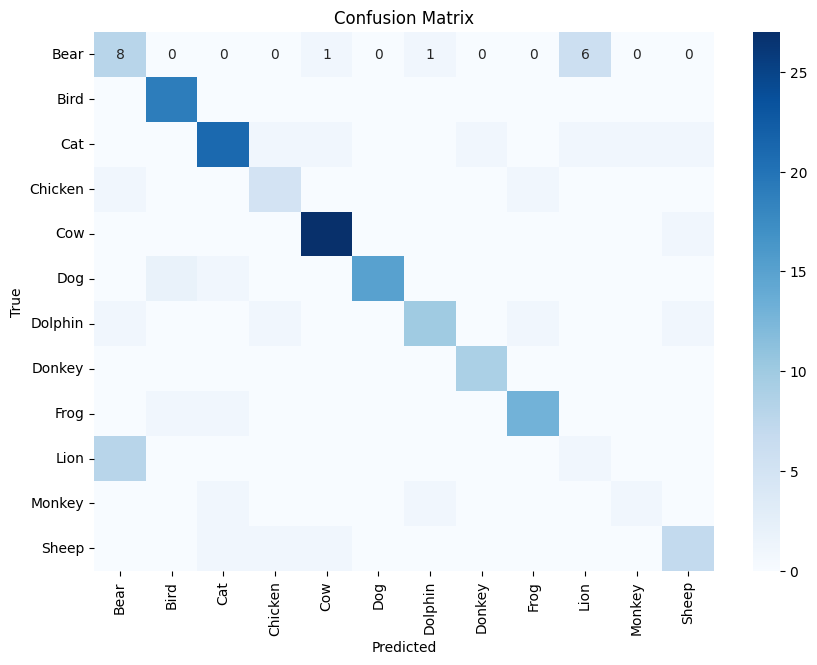

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict the classes for the test set
y_pred_probs = rnn_model.predict(X_test_rnn)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted classes
y_true = np.argmax(y_test, axis=1)  # True classes

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()